# <font color='blue'>Advanced Challenge: Variational Quantum Unsampling:</font> 

Here we provide you some introductory material to get you started on the main challenge, 
the results of which you will be presenting tomorrow.

In this challenge, you will be investigating a recently defined algorithm,
called 'Variational Quanutm Unsampling' 

(https://arxiv.org/abs/1904.10463)

This is a variational algorithm, whose goal is to determine which process created a particular 
quantum state which is fed into it.

Essentially, it tries to determine some unitary, $U$, which created the state:

\begin{align}
\left|\psi_{\text{out}}\right> = U\left|\psi_{\text{in}}\right>
\end{align}

when applied to some (known) reference state, $\left|\psi_{\text{in}}\right>$

The algorithm does this by applying some parameterised unitary operation, $V(\theta)$, on the state $\left|\psi_{\text{out}}\right>$ in order to return it to the reference state, $\left|\psi_{\text{in}}\right>$. In other words, it attempts to find the ***inverse*** of the target unitary, $U$, such that:

\begin{align}
\left|\psi_{\text{in}}\right> =  V(\theta)U\left|\psi_{\text{in}}\right>
\end{align}

This is achieved by minimising some cost function, relative to the parameters, $\theta$, which describes the discrepancy between the target, and the current state of the system at any point during the optimisation procedure.

First import the usual things:

In [ ]:
from pyquil import Program
from pyquil.api import get_qc, WavefunctionSimulator, local_qvm
from pyquil.gates import *
import numpy as np
import os, inspect, sys

import sys
sys.path.insert(0, 'tests/')

make_wf = WavefunctionSimulator()

## <font color='green'>Practicalities:</font> 

Actually optimising the parameters, $\theta$, of an $n$-qubit state properly would be extremely difficult, if all the measurements were performed at the end. 

Instead a solution is to break the unitary, $V(\theta)$ into a number of smaller unitaries:



$V_n(\vec{\theta}_n), V_{n-1}(\vec{\theta}_{n-1}), \dots V_1(\vec{\theta}_1)$, where $V_i$ acts on $i$ qubits only.

After **each** unitary is performed, a *single* qubit is measured, and the measurement results are used to optimise the parameters of said unitary.


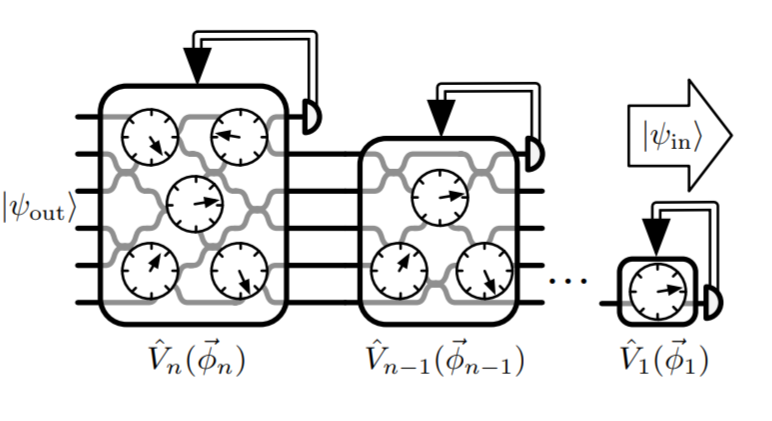

# <font color='orange'>Loss function:</font> 


As is standard in Machine Learning, we must define some loss function to determine how well we are doing during training.

In this case, the loss function will tell us how close the output was to the input, measured by the inner product of the two states.

Firslty, imagine we did not break up the unitary, $V(\theta)$, which evolved the output states, $\left|\psi_{out}\right>$, to some final state:

\begin{align}
\left|\phi\right> = V(\theta)\left|\psi_{\text{out}}\right>
\end{align}

In this case, we want to see how well we are doing, by measuring the *squared overlap* between the states $\left|\phi\right>$ and the target state, $\left|\psi_{\text{in}}\right>$:

\begin{align}
L = 1 - \left|\left<\phi|\psi_{\text{out}}\right>\right|^2
\end{align}

This is the same as taking the *inner product* between the vectors $\left|\phi\right>, \left|\psi_{\text{out}}\right>$. If these vectors are identical, i.e. $\left|\phi\right> = \left|\psi_{\text{out}}\right>$, then their inner product will be $1$.
In this case, the above cost function, $L$, will be $0$ and we have achieved an optimal minimum.

Unfortunately, as mentioned above, this overlap may be exponentially small, i.e. the probability of ending in the
state $\left|\psi_{\text{in}}\right>$ may be very small, especially as the number of qubits grows.

A solution is to break up the unitary to the smaller ones above, and sequentially minimise a *sequence* of loss functions,one for each qubit that is measured.

For example, if we assume that our input state was a product state: $|\vec{\alpha}\rangle = |\alpha_1\rangle\otimes\dots |\alpha_n\rangle$, then we can optimise a 'local' cost function **per single qubit state**, $\left|\alpha_i\right>$

\begin{align}
L_i = 1 - \left|\left<\alpha_i\right|\mathsf{Tr}_{-i}\left(\rho\right)\left|\alpha_i\right>\right|^2
\end{align}

**Note: $\mathsf{Tr}_{-i}(\rho)$ denotes the partial trace of a quantum density matrix, $\rho$, including all subsystems except $i$**

*Example: if we have the following state of three qubits, $\left|\psi\right> = \left|a\right> \otimes\left|b\right> \otimes\left|c\right>$, which has a corresponding density matrix*:

*$\rho = \left|a\right>\left<a\right| \otimes\left|b\right>\left<b\right| \otimes\left|c\right>\left<c\right|$* (for pure states, the density matrix is given by the outer product of $\left|\psi\right>$ with itself, $\rho = \left|\psi\right>\left<\psi\right|$

*Then the partial trace over all but system $b$ (for example) is:*

\begin{align}
\mathsf{Tr}_{-b}(\rho) = \left(\left|a\right>\left<a\right| \otimes\left|b\right>\left<b\right| \otimes \left|c\right>\left<c\right|\right) =  \left|b\right>\left<b\right| \mathsf{Tr}\left(\left|a\right>\left<a\right| \otimes \left|c\right>\left<c\right|\right) = \left|b\right>\left<b\right| \mathsf{Tr}\left(\left<a|a\right> \otimes \left<c|c\right>\right) = \left|b\right>\left<b\right|
\end{align}

# How does the algorithm work?

We will use a specific case of the algorithm and consider $\left|\psi_{\text{in}}\right> = |00\dots 0\rangle$ to be a product state.

## <font color='red'>Input:</font> 

A state prepared by some unknown unitary, $U|00\dots 0\rangle$

For each round, $i: n \rightarrow 1$, apply $i^{th}$ parameterised unitary, $V(\vec{\theta}_i)$, and measure $i^{th}$ qubit fidelity from $\|0\rangle$ state. Compute Loss function, L_i, and update parameters, $\vec{\theta}_i$ using some minimiser.

## <font color='blue'>Output:</font> 

Optimal angles, $\vec{\theta}_n, \dots, \vec{\theta}_1$ to approximate target unitary, $U$.


We start with a simple example, a two qubit entangled state, which is similar to a Bell state, prepared by the following circuit:

\begin{align}
U_{Targ}|00\rangle = CRX(\theta_1)_{0, 1}(R_y(\theta_2) \otimes \mathbb{1})|00\rangle
\end{align}

$CRX(\theta_1)_{0, 1}$ is a controlled rotation around the Pauli-X axis, by an angle $\theta$:

\begin{align}
CRX(\theta_1)_{0, 1} = \left(\begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & \cos(\frac{\theta}{2}) &  -i\sin(\frac{\theta}{2})\\
0 & 0 & -i \sin(\frac{\theta}{2}) &  \cos(\frac{\theta}{2})
\end{array}
\right)
\end{align}

We will use this gate since it is similar to the $CNOT/CX$ gate: The Pauli $X$ gate is a rotation around the $X$ axis by an angle $\pi$ (up to a phase), but it is parameterised so you can see if the algorithm can find the correct parameter.

Similarly, we use the $R_y$ gate instead of a Hadamard:

\begin{align}
R_y(\theta_2) = \left(\begin{array}{cc}
\cos(\frac{\theta}{2}) &  -\sin(\frac{\theta}{2})\\
 \sin(\frac{\theta}{2}) &  \cos(\frac{\theta}{2})
\end{array}
\right)
\end{align}

For $\theta_2 = \frac{\pi}{2}$, we get a state which has a similar effect as the Hadamard gate.

In [ ]:
# Let's define the computer we want to use first
qc_name = "3q-qvm"
qc =get_qc(qc_name)
qubits = qc.qubits()

We need to define the Control-RX gate, since it is not built into Pyquil:
(http://docs.rigetti.com/en/stable/basics.html#defining-parametric-gates)

In [ ]:
from pyquil.parameters import Parameter, quil_sin, quil_cos
from pyquil.quilbase import DefGate

# Define the new gate from a matrix
theta = Parameter('theta')
crx = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, quil_cos(theta / 2), -1j * quil_sin(theta / 2)],
    [0, 0, -1j * quil_sin(theta / 2), quil_cos(theta / 2)]
])

gate_definition = DefGate('CRX', crx, [theta])
CRX = gate_definition.get_constructor()


Now we measure qubit $1$ and try and maximise the probability that it is the $|0\rangle$ state.

Note that since $CRX(\theta)^\dagger = CRX(-\theta)$, the angle we want to find will be the negative of the value we input.

In [ ]:
num_trials = 1000
# num_trials = # How many measurement shots should we use?

params = np.random.rand(1) # We will start with one random parameter.

import scipy.optimize as opt # We will use a black-box optimisation routine here.

def cost_func_two_qubit_gate(params, qubits):
    circuit = Program()
    circuit += gate_definition # We need to define the new gate in each program we use it in.

    ro = circuit.declare('ro', 'BIT', 1)
    target_two_qubit_angle = 0.444 # This is the angle we want to optimise for in this step.
    target_single_qubit_angle = 0.7822
    
    print('The target parameter is:', -target_two_qubit_angle)
    
    circuit += RY(target_single_qubit_angle, qubits[0])
    circuit += CRX(target_two_qubit_angle)(qubits[0], qubits[1])
    
    # What gate should be applied here to get qubit one to return to the |0> state?
#     circuit += # Add gates here
    
    print('The current parameter value is:', params[0])
    circuit += MEASURE(qubits[1], ro[0])
    circuit.wrap_in_numshots_loop(num_trials)

    executable = qc.compile(circuit)
    
    results = qc.run(executable)
    prob_zero = list(results).count([0])/num_trials 
    
    # We want to minimise this value, by making the probability of observing qubit *one* in the state |0> close to 1
    cost_func = 1 - prob_zero 

    return cost_func

# result = opt.minimize(cost_func_two_qubit_gate, params, args=(qubits), method='Powell')

# print('The optimised parameter value found is: ', result.x)

Try changing the number of measurement shots which are applied to qubit 1. How does this affect the performance of the optimiser?

Now, we have optimised the two qubit gate parameter. Next we will learn the correct parameter of the single qubit gate. We will use the optimised value of the parameter found in the previous section.

In [ ]:
num_trials = 1000

def cost_func_both_gates(params, optimised_two_q_param, qubits):
    circuit = Program()
    circuit += gate_definition # We need to define the new gate in each program we use it in.

    ro = circuit.declare('ro', 'BIT', 1)
    target_two_qubit_angle = 0.444 
    target_single_qubit_angle = 0.7822 # This is the angle we want to optimise for in this step.
    print('The target parameter is:', -target_single_qubit_angle)
    
    circuit += RY(target_single_qubit_angle, qubits[0])
    circuit += CRX(target_two_qubit_angle)(qubits[0], qubits[1])

#     circuit += # Add the optimised gate over 2 qubits here, that you found above
#     circuit += # Now put the gate with the parameter to optimise here
    
    print('The current parameter value is:', params[0])

    circuit += MEASURE(qubits[0], ro[0])
    circuit.wrap_in_numshots_loop(num_trials)

    executable = qc.compile(circuit)
    results = qc.run(executable)
    prob_zero = list(results).count([0])/num_trials 
    
    # We want to minimise this value, by making the probability of observing |0> in qubit *zero* close to 1
    cost_func = 1 - prob_zero 

    return cost_func


result_two_qubit_opt = opt.minimize(cost_func_two_qubit_gate, np.array(params[0]), args=(qubits), method='Powell')

optimised_two_q_param = np.asscalar(result_two_qubit_opt.x)
params = np.random.rand(1) # We will start with one random parameter for the single qubit gate.
print(params)

result_single_qubit_opt = \
opt.minimize(cost_func_both_gates, params, args=(optimised_two_q_param, qubits), method='Powell')

optimised_single_q_param = result_single_qubit_opt.x

Now, take those optimised parameters, and plug them into the circuit you found to see if it the state of the system ends up (close to) the $|00>$ state.

In [ ]:
optimised_params = np.array([optimised_two_q_param, optimised_single_q_param])

circuit_optimised = Program()
circuit_optimised += gate_definition # We need to define the new gate in each program we use it in.

ro = circuit_optimised.declare('ro', 'BIT', 1)
target_angles = np.array([0.444, 0.7822]) # Define the target angles again

circuit_optimised += RY(target_angles[1], qubits[0])
circuit_optimised += CRX(target_angles[0])(qubits[0], qubits[1])

# circuit_optimised += # Apply the unitaries V_2, V_1, that you found here with the optimised parameters

with local_qvm():
    wavefunction = make_wf.wavefunction(circuit_optimised)

print(wavefunction)

print(wavefunction.get_outcome_probs())

What state did you end up in? Was it close to $|00\rangle$?

# Challenge (Optional)

***This section will test your understanding of the algorithm, but if you are running short on time, then feel free to skip it and do a different challenge, since it will be time-consuming.***

Now that you have a feel for the algorithm, you will be given **unknown** states over two qubits, for which you must try and return them to the zero state.

Since you do not know the unitary that prepared them, you cannot just apply the same gates again and optimise the parameters as above above. 

You should pick a good *ansatz* circuit, and try an optimise the parameters to get as close as you can to returning the state to the $|00\rangle$ state.

*Note: the ansatz on each subset of qubits does not have to consist of only a single gate.*

In [ ]:
from auxiliary_functions.unsampling_unitaries import *


The functions:

state_one_prep,

state_two_prep and

state_three_prep

will each prepare a particular state. You can use them as a subroutine in your functions, instead of explicitly 
adding initial gates to a circuit as we did above.


In [ ]:
# Use as follows:

circuit = Program()
circuit = state_two_prep(circuit, qubits) # qubits is the list of qubits we get from the quantum device as above.

## You can check the state that is produced by printing the wavefunction, but beware this is not 
## something you can do in general!!

with local_qvm():
    wavefunc = make_wf.wavefunction(circuit)
print(wavefunc)

Now find the approximate unitaries which return each of these states to the $|00\rangle$ state.